In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io
import tensorflow_model_optimization as tfmot
import re

In [2]:
labels = pd.read_csv("gs://dataset-gabon/data_training_extra/Labels/labels_clean.csv")
train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv", header=None)
val_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv", header=None)
test_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren.csv", header=None)
CLASS_NAMES = train_data[0].unique()

In [3]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3

BATCH_SIZE = 128
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [4]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [5]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8

def read_and_preprocess(image_bytes, label, random_augment=False):
#     if random_augment:
#         img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
#         img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, MAX_DELTA)
#         img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
#     else:
    img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

In [6]:
def decode_csv(csv_row):
    record_defaults = ["img", "path"]
    label_string, filename = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

In [7]:
def load_dataset(csv_of_filenames, batch_size, training=True):    
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        dataset = dataset \
            .map(read_and_preprocess_with_augment) \
            .repeat(count=1)
#                 .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=None)  # Indefinately.

#         dataset = dataset \
#             .map(read_and_preprocess_with_augment) \
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=None)  # Indefinately.
    else:
        dataset = dataset \
            .map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .repeat(count=1)  # Each photo used once.
    
    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
#     return dataset.range(4).interleave(lambda _: dataset.batch(batch_size=batch_size), num_parallel_calls=tf.data.AUTOTUNE )

# Model

In [14]:
# data
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv"
nclasses = len(CLASS_NAMES)

In [23]:
model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [24]:
model.trainable = False

In [17]:
# inputs = keras.Input(shape=(299, 299, 3))
# # We make sure that the base_model is running in inference mode here,
# # by passing `training=False`. This is important for fine-tuning, as you will
# # learn in a few paragraphs.
# x = model(inputs, training=False)
# # Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(rate=0.5)(x)
# # A Dense classifier with a single unit (binary classification)
# outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
# model_for_pruning = keras.Model(inputs, outputs)

In [29]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = len(train_data) * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_for_pruning.summary()

In [30]:
inputs = keras.Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = model_for_pruning(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate=0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
model_for_pruning = keras.Model(inputs, outputs)

In [31]:
# model_for_pruning.load_weights("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/cp.ckpt")

In [32]:
model_for_pruning.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      41406643  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 28)                57372     
Total params: 41,464,015
Trainable params: 57,372
Non-trainable params: 41,406,643
_________________________________________________________________


In [34]:
model_for_pruning.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [ ]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

model_for_pruning.fit(train_ds,
                  epochs=1,
                  validation_data=eval_ds,
                  callbacks=callbacks)

   1889/Unknown - 3753s 2s/step - loss: 1.2869 - accuracy: 0.6215

In [37]:
model_for_pruning.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [38]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/Xception_pruned/cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = model_for_pruning.fit(train_ds,
            epochs=1,
            validation_data=eval_ds,
            callbacks=[cp_callback]
         )

    782/Unknown - 1568s 2s/step - loss: 1.5009 - accuracy: 0.5716

# save model

In [ ]:
tf.keras.models.save_model(model, "gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/Xception_pruned/model.H5", 
                           include_optimizer=False)

# pruning

In [18]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

model_for_pruning.fit(train_ds,
                  epochs=1,
                  validation_data=eval_ds,
                  callbacks=callbacks)

1904/1904 [==============================] - 2658s 1s/step - loss: 1.0503 - accuracy: 0.6615 - val_loss: 0.8704 - val_accuracy: 0.7172


In [19]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [20]:
tf.keras.models.save_model(model_for_export, "gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/Xception_pruned/model_pruned.H5", 
                           include_optimizer=False)

INFO:tensorflow:Assets written to: gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/Xception_pruned/model_pruned.H5/assets


In [23]:
model_for_pruning.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        4383708   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 29)                37149     
Total params: 4,420,857
Trainable params: 37,149
Non-trainable params: 4,383,708
_________________________________________________________________


In [22]:
for layers in model_for_pruning:
    print(layers)

TypeError: 'Functional' object is not iterable

# Results

In [28]:
test_path = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren.csv"
test_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [35]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=len(test_data)//BATCH_SIZE)
print(test_acc)

475/475 [==============================] - 139s 292ms/step - loss: 2.5923 - accuracy: 0.3417
0.3417434096336365


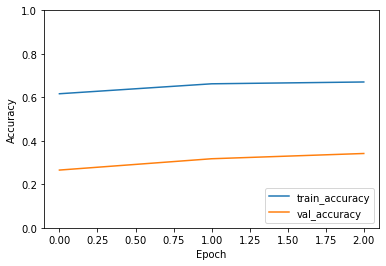

In [30]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

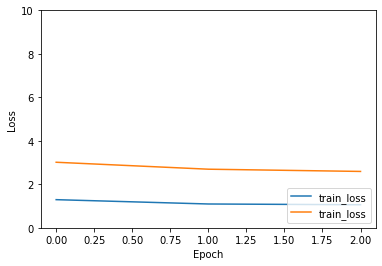

In [32]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(loc='lower right')

In [37]:
# PREDICTIONS = 200
# y_test = []
# counter = 0
# for i in tqdm(test_ds):
#     if counter < PREDICTIONS:
#         counter += 1
#         for j in i[1]:
#             y_test.append(np.where(j == True)[0][0])
#     else:
#         break
# print(len(y_test))

200it [00:33,  5.91it/s]

25600


In [36]:
# import seaborn as sn
# y_pred = np.argmax(model.predict(test_ds, steps=PREDICTIONS), axis=1)
# confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) 
# plt.figure(figsize=(10, 8))
# sn.heatmap(confusion_mtx, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, 
#             annot=True, fmt='g')
# plt.xlabel('Prediction')
# plt.ylabel('Label')
# plt.show()

NameError: name 'y_test' is not defined